<a href="https://colab.research.google.com/github/ddrodionova/NNMethods_4th_year/blob/main/NNMethods_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks in NLP HW 3

## Дарья Родионова БКЛ182

Импортируем нужные модули.

In [1]:
!pip install --quiet torchmetrics

     |████████████████████████████████| 332 kB 7.1 MB/s 


In [53]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import nltk
from nltk import word_tokenize


nltk.download('punkt')


from matplotlib import pyplot as plt
%matplotlib inline
%pylab inline
import seaborn as sns


from collections import Counter


from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.functional import f1
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import torch.optim as optim
from torch.autograd import Variable

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
data = pd.read_csv('Fake.csv')
data

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [5]:
data.drop(columns=['date'], inplace=True)

### Preprocessing

Чистим данные перед обучением модели.

In [6]:
def preprocess(text):
    return ' '.join(word_tokenize(text.lower()))

In [7]:
data['clean_data'] = data['text'].apply(lambda x: preprocess(x))

In [8]:
data['target'] = data.subject.astype('category').cat.codes
data.head()

,title,text,subject,clean_data,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,donald trump just couldn t wish all americans ...,2
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,house intelligence committee chairman devin nu...,2
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"on friday , it was revealed that former milwau...",2
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"on christmas day , donald trump announced that...",2
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,pope francis used his annual christmas day mes...,2


In [9]:
data['target'].unique()

array([2, 5, 0, 4, 3, 1], dtype=int8)

Посмотрим на дистрибуцию классов. 

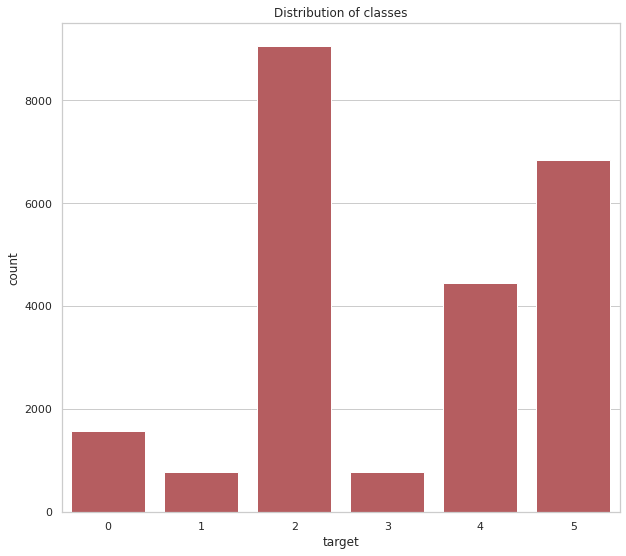

In [10]:
sns.set_theme(style='whitegrid')


plt.figure(figsize=(10, 9))
plt.title('Distribution of classes')
sns.countplot(x='target', data=data, color='r')
plt.show()

In [11]:
vocab = Counter()


for text in tqdm(data.clean_data):
    vocab.update(text.split())
print('Всего уникальных токенов: ', len(vocab))

  0%|          | 0/23481 [00:00<?, ?it/s]

Всего уникальных токенов:  181384


In [12]:
filtered_vocab = set()


for word in vocab:
    if vocab[word] > 3:
        filtered_vocab.add(word)
print('Уникальных символов, втретившихся больше 3 раз: ', len(filtered_vocab))

Уникальных символов, втретившихся больше 3 раз:  48324


In [13]:
word2id = {'UNK':0}


for word in filtered_vocab:
    word2id[word] = len(word2id)

Сплитим данные.

In [14]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, 
                                         random_state=42)

In [15]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

### Dataset

In [16]:
class MyDataSet(Dataset):

    def __init__(self, dataset, word2id, DEVICE, max_len):
        self.dataset = dataset['clean_data'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.device = DEVICE
        self.max_len = MAX_LEN
        self.target = torch.Tensor(dataset['target'].values)
    
    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = self.dataset[index].split()
        ids = torch.LongTensor([self.word2id[word] if word in self.word2id 
                                else self.word2id['UNK'] for 
                                word in words][:self.max_len])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
      ids, y = list(zip(*batch))
      padded_ids = torch.vstack([F.pad(
          seq, pad=(0, self.max_len - seq.shape[0]), mode='constant', 
          value=0) for seq in ids])
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.LongTensor(y).to(self.device)
      return padded_ids, y.T[0]

In [17]:
MAX_LEN = max(train_data['clean_data'].str.split().apply(len))
MAX_LEN

9938

Увы, экспрерименты показали, что это очень много для Google Colab, поэтому установим длину вручную.

In [18]:
MAX_LEN = 500

In [19]:
train_dataset = MyDataSet(train_data, word2id, DEVICE, MAX_LEN)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=128)

In [20]:
test_dataset = MyDataSet(test_data, word2id, DEVICE, MAX_LEN)
test_sampler = SequentialSampler(test_dataset)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, sampler=test_sampler, batch_size=128)

Как и в статье, используем эмбеддинги Google.

In [21]:
! wget -c 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'

--2021-12-28 12:58:50--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.169.125
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.169.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  24.2MB/s    in 51s     

2021-12-28 12:59:41 (31.0 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [22]:
from gensim.models import KeyedVectors


news_path = 'GoogleNews-vectors-negative300.bin.gz'
w2v = KeyedVectors.load_word2vec_format(news_path, binary=True)

In [23]:
weights = np.zeros((len(word2id), 300))
for word, i in word2id.items():
    try:
        weights[i] = w2v.wv[word]    
    except KeyError:
      weights[i] = np.random.uniform(-0.25, 0.25, 300)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


### Model

Собственно сама модель, которая описана в статье.

In [24]:
class CNN_LSTM(nn.Module):

    def __init__(self, vocab_size, embedding_dim, filter_number,
                 filter_size, hidden_size, num_layers,
                 dropout=None, dropout_per=0, weights=None):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.filter_number = filter_number
        self.filter_size = filter_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv_layers = len(filter_size)
        self.dropout_param = dropout

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        if type(weights) == np.ndarray:
            self.embedding.from_pretrained(torch.tensor(weights))
        self.conv = []
        self.conv2 = nn.Conv1d(in_channels=self.embedding_dim, 
                              out_channels=self.filter_number, 
                              kernel_size=2,
                              padding='valid')
        self.conv3 = nn.Conv1d(in_channels=self.embedding_dim, 
                              out_channels=self.filter_number, 
                              kernel_size=3,
                              padding='valid')
        self.conv3 = nn.Conv1d(in_channels=self.embedding_dim, 
                              out_channels=self.filter_number, 
                              kernel_size=4,
                              padding='valid')
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(
            input_size=(self.filter_number*self.conv_layers),
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )
        self.linear = nn.Linear(self.hidden_size, 6)
        self.dropout = nn.Dropout(p=dropout_per)

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        
        if self.dropout_param == 'before':
            embedded = self.dropout(embedded)
        conv_layers = []
        
        if 2 in self.filter_size:
            conv_layers.append(self.relu(self.conv2(embedded)).transpose(1,2))
        
        if 3 in self.filter_size:
            conv_layers.append(self.relu(self.conv2(embedded)).transpose(1,2))
        
        if 4 in self.filter_size:
            conv_layers.append(self.relu(self.conv2(embedded)).transpose(1,2))
        
        for i, layer in enumerate(conv_layers):
            if i == 0:
              length = layer.shape[1]
              conv_layer = layer
            else:
              conv_layer = torch.cat((conv_layer, layer[:,:length,:]), 2)
        
        lstm_out, (ht, ct) = self.lstm(conv_layer)
        lstm_layer = ht[-1]

        if self.dropout_param == 'after':
            logits = self.dropout(lstm_layer) 
        logits = self.linear(lstm_layer)
        
        return logits

In [25]:
def train(model, iterator, optimizer, criterion, metric, device):
    
    epoch_loss = 0
    epoch_metric = 0
    model.train()

    for i, (texts, ys) in enumerate(iterator):
        optimizer.zero_grad()
        texts = texts.to(device)
        ys = ys.to(device)
        preds = model(texts.squeeze())
        loss = criterion(preds, ys.long())  

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        batch_metric = metric(preds, ys.long(), ignore_index=0)
        epoch_metric += batch_metric
    print(f'F-score: {epoch_metric / len(iterator)}, loss: {epoch_loss / len(iterator)}') 
    return epoch_metric / len(iterator), epoch_loss / len(iterator)

In [26]:
def evaluate(model, iterator, criterion, metric, device):
    
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 

    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):
            texts = texts.to(device)
            ys = ys.to(device) 
            preds = model(texts.squeeze())

            loss = criterion(preds, ys.long())
            
            epoch_loss += loss.item()
            batch_metric = metric(preds, ys.long(), ignore_index=0)
            epoch_metric += batch_metric

    print(f'F-score: {epoch_metric / len(iterator)}, loss: {epoch_loss / len(iterator)}')   
    return epoch_metric / len(iterator), epoch_loss / len(iterator)

In [29]:
def model_perfomance(model, criterion, optimizer, DEVICE, epochs,
                  train_iterator, val_iterator):
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)
    losses = []
    val_losses= []
    f1s = []
    val_f1s = []

    for epoch in tqdm(range(epochs)):
        print('\n======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
        print('Evaluating on train...')
        f1_on_train, epoch_loss = train(model, train_iterator, optimizer, 
                                     criterion, metric=f1, device=DEVICE)
        losses.append(epoch_loss)
        f1s.append(f1_on_train)

        print('Evaluating on test...')
        f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, 
                                                  criterion, metric=f1, 
                                                  device=DEVICE)
        val_losses.append(epoch_loss_on_test)
        val_f1s.append(f1_on_test)
    return losses, val_losses, f1s, val_f1s

Посмотрим на работу модели: сначала прогоним на дефолтных параметрах, с одним слоём свёртки и размерностями 150.

In [30]:
model = CNN_LSTM(len(train_dataset.word2id), embedding_dim=300, 
                 filter_number=150, filter_size=[2], hidden_size=150, 
                 num_layers=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())
losses, val_losses, f1s, val_f1s = model_perfomance(model, criterion, optimizer,
                                                   DEVICE, 5, train_iterator,
                                                   test_iterator)

  0%|          | 0/5 [00:00<?, ?it/s]


======== Epoch 1 / 5 ========
Evaluating on train...
F-score: 0.3515632152557373, loss: 1.601293582494567
Evaluating on test...
F-score: 0.2963302433490753, loss: 1.5726507483301937

======== Epoch 2 / 5 ========
Evaluating on train...
F-score: 0.37742677330970764, loss: 1.4786983379701368
Evaluating on test...
F-score: 0.40031731128692627, loss: 1.4694278981234576

======== Epoch 3 / 5 ========
Evaluating on train...
F-score: 0.3945677876472473, loss: 1.4660689173912516
Evaluating on test...
F-score: 0.39759695529937744, loss: 1.5538829822798033

======== Epoch 4 / 5 ========
Evaluating on train...
F-score: 0.5148259997367859, loss: 1.3312795064887222
Evaluating on test...
F-score: 0.3991243541240692, loss: 1.323366361695367

======== Epoch 5 / 5 ========
Evaluating on train...
F-score: 0.5961200594902039, loss: 1.1799951698504338
Evaluating on test...
F-score: 0.5232746005058289, loss: 1.3562797984561406


In [31]:
def plot_losses(losses, val_losses, f1s, val_f1s):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].plot(losses)
    ax[0].plot(val_losses)
    ax[0].set_title('CE loss value')
    ax[0].set_ylabel('CE loss')
    ax[0].set_xlabel('epochs')
    ax[0].legend(['train', 'val'], loc='upper right')
 
    ax[1].plot(f1s)
    ax[1].plot(val_f1s)
    ax[1].set_title('F1 value')
    ax[1].set_ylabel('F1 value')
    ax[1].set_xlabel('epochs')
    
    plt.show()

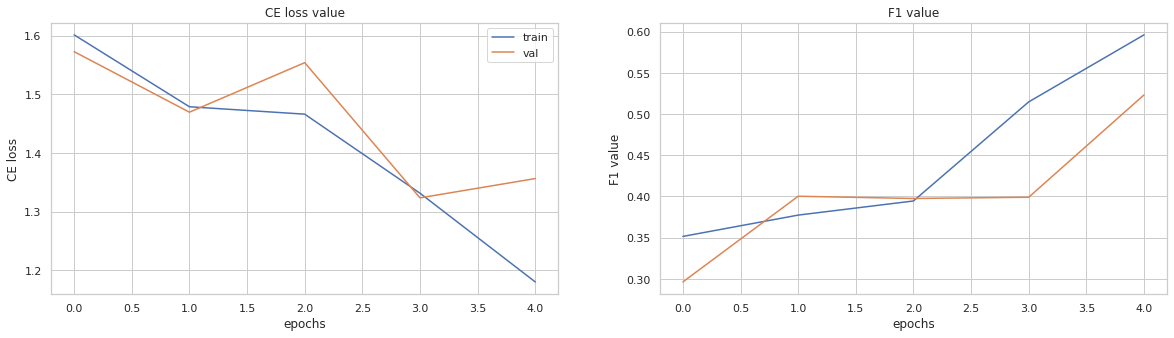

In [32]:
plot_losses(losses, val_losses, f1s, val_f1s)

Попробуем добавить L2-регуляризацию.

In [33]:
model = CNN_LSTM(len(train_dataset.word2id), embedding_dim=300, 
                 filter_number=150, filter_size=[2], hidden_size=150, 
                 num_layers=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), weight_decay=0.001)
losses, val_losses, f1s, val_f1s = model_perfomance(model, criterion, optimizer,
                                                   DEVICE, 5, train_iterator,
                                                   test_iterator)

  0%|          | 0/5 [00:00<?, ?it/s]


======== Epoch 1 / 5 ========
Evaluating on train...
F-score: 0.49185433983802795, loss: 1.361227776323046
Evaluating on test...
F-score: 0.40909498929977417, loss: 2.559871770240165

======== Epoch 2 / 5 ========
Evaluating on train...
F-score: 0.592286229133606, loss: 1.0995542285393696
Evaluating on test...
F-score: 0.6189482808113098, loss: 1.0525336491095054

======== Epoch 3 / 5 ========
Evaluating on train...
F-score: 0.6110881567001343, loss: 1.0490851527979586
Evaluating on test...
F-score: 0.6156714558601379, loss: 1.1145734980299666

======== Epoch 4 / 5 ========
Evaluating on train...
F-score: 0.6060976982116699, loss: 1.0736787092118036
Evaluating on test...
F-score: 0.6025059819221497, loss: 1.0798675691759265

======== Epoch 5 / 5 ========
Evaluating on train...
F-score: 0.6002103686332703, loss: 1.0427937941486334
Evaluating on test...
F-score: 0.6339870095252991, loss: 0.9594103629524643


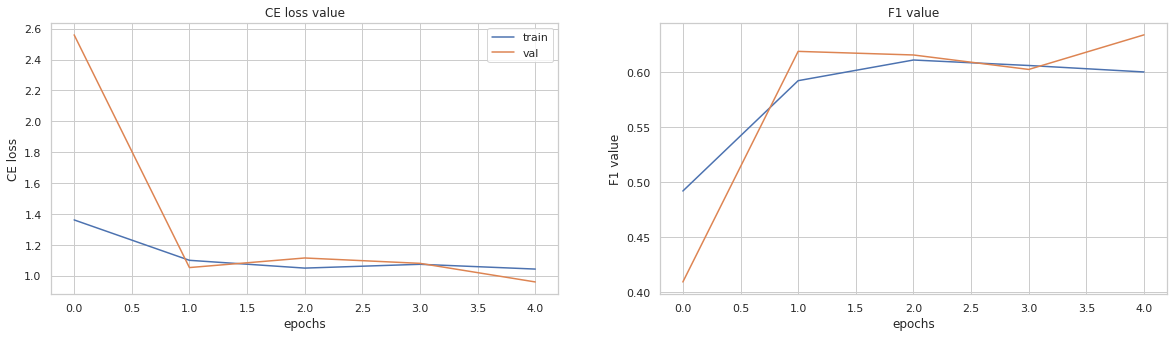

In [34]:
plot_losses(losses, val_losses, f1s, val_f1s)

Стало чуть получше, попробуем обучить на предобученных весах.

In [35]:
model = CNN_LSTM(len(train_dataset.word2id), embedding_dim=300, 
                 filter_number=150, filter_size=[2], hidden_size=150, 
                 num_layers=1, weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), weight_decay=0.001)
losses, val_losses, f1s, val_f1s = model_perfomance(model, criterion, optimizer,
                                                   DEVICE, 5, train_iterator,
                                                   test_iterator)

  0%|          | 0/5 [00:00<?, ?it/s]


======== Epoch 1 / 5 ========
Evaluating on train...
F-score: 0.4896122217178345, loss: 1.3821450820585497
Evaluating on test...
F-score: 0.6186617612838745, loss: 1.0547569490767814

======== Epoch 2 / 5 ========
Evaluating on train...
F-score: 0.6028640270233154, loss: 1.0413990787097387
Evaluating on test...
F-score: 0.5889332890510559, loss: 1.053843322637919

======== Epoch 3 / 5 ========
Evaluating on train...
F-score: 0.6029893755912781, loss: 1.0320639845465316
Evaluating on test...
F-score: 0.6381993889808655, loss: 0.9311130352922388

======== Epoch 4 / 5 ========
Evaluating on train...
F-score: 0.6258842945098877, loss: 0.9557333641311749
Evaluating on test...
F-score: 0.6377713680267334, loss: 0.9392011149509533

======== Epoch 5 / 5 ========
Evaluating on train...
F-score: 0.6220066547393799, loss: 0.9470503723540273
Evaluating on test...
F-score: 0.6319287419319153, loss: 0.9469477131560042


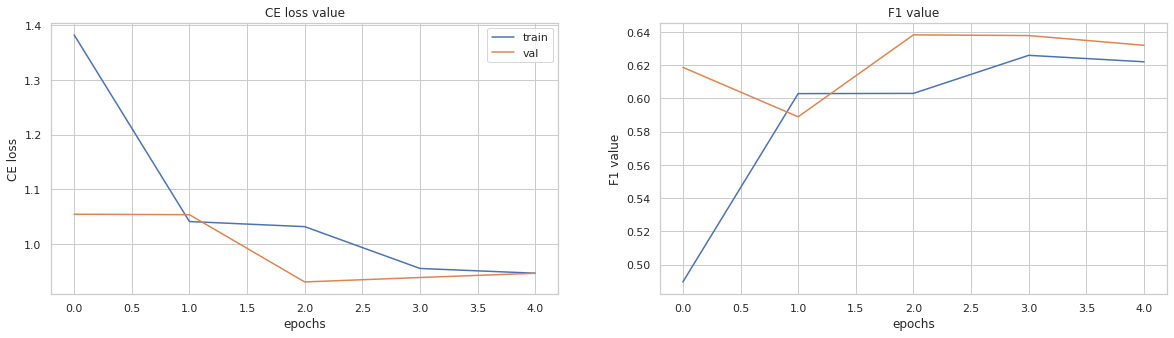

In [36]:
plot_losses(losses, val_losses, f1s, val_f1s)

Добавим learning rate.

In [37]:
model = CNN_LSTM(len(train_dataset.word2id), embedding_dim=300, 
                 filter_number=150, filter_size=[2], hidden_size=150, 
                 num_layers=1, weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.00001, weight_decay=0.001)
losses, val_losses, f1s, val_f1s = model_perfomance(model, criterion, optimizer,
                                                   DEVICE, 5, train_iterator,
                                                   test_iterator)

  0%|          | 0/5 [00:00<?, ?it/s]


======== Epoch 1 / 5 ========
Evaluating on train...
F-score: 0.30883723497390747, loss: 1.650576638526657
Evaluating on test...
F-score: 0.37357261776924133, loss: 1.566469930313729

======== Epoch 2 / 5 ========
Evaluating on train...
F-score: 0.392808735370636, loss: 1.525096801673474
Evaluating on test...
F-score: 0.400948166847229, loss: 1.5047485667306024

======== Epoch 3 / 5 ========
Evaluating on train...
F-score: 0.3979950249195099, loss: 1.4828728064387835
Evaluating on test...
F-score: 0.4011715352535248, loss: 1.4755934670164779

======== Epoch 4 / 5 ========
Evaluating on train...
F-score: 0.3980575203895569, loss: 1.4589251247393031
Evaluating on test...
F-score: 0.4011715352535248, loss: 1.4574265447822776

======== Epoch 5 / 5 ========
Evaluating on train...
F-score: 0.3980666697025299, loss: 1.4460486092535005
Evaluating on test...
F-score: 0.4011715352535248, loss: 1.4491488901344505


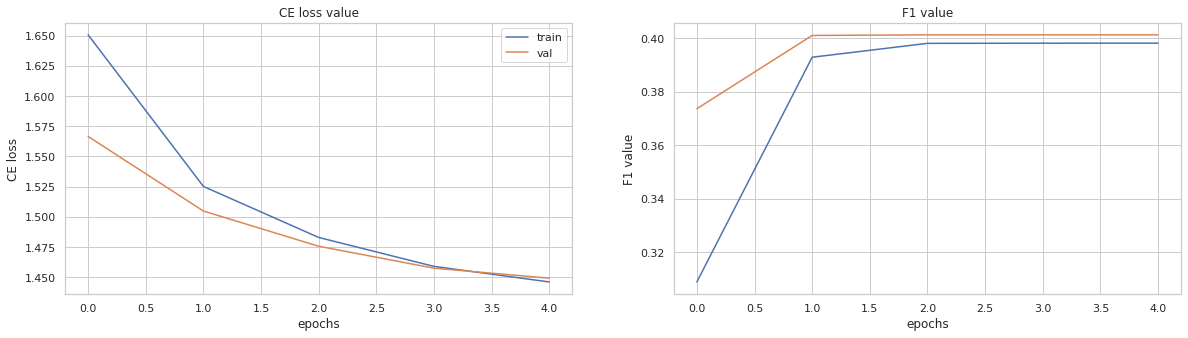

In [38]:
plot_losses(losses, val_losses, f1s, val_f1s)

Стало хуже, попробуем немного изменить learning rate.

In [39]:
model = CNN_LSTM(len(train_dataset.word2id), embedding_dim=300, 
                 filter_number=150, filter_size=[2], hidden_size=150, 
                 num_layers=1, weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.001)
losses, val_losses, f1s, val_f1s = model_perfomance(model, criterion, optimizer,
                                                   DEVICE, 5, train_iterator,
                                                   test_iterator)

  0%|          | 0/5 [00:00<?, ?it/s]


======== Epoch 1 / 5 ========
Evaluating on train...
F-score: 0.5060797333717346, loss: 1.2869026628481288
Evaluating on test...
F-score: 0.6121301054954529, loss: 1.0269115599426064

======== Epoch 2 / 5 ========
Evaluating on train...
F-score: 0.627801775932312, loss: 0.9616103776458169
Evaluating on test...
F-score: 0.6337472796440125, loss: 1.0301941359365308

======== Epoch 3 / 5 ========
Evaluating on train...
F-score: 0.651785671710968, loss: 0.8841608847890582
Evaluating on test...
F-score: 0.6511180996894836, loss: 0.8872218083690953

======== Epoch 4 / 5 ========
Evaluating on train...
F-score: 0.6550073027610779, loss: 0.8730525938021082
Evaluating on test...
F-score: 0.6472254991531372, loss: 0.8827947200955572

======== Epoch 5 / 5 ========
Evaluating on train...
F-score: 0.6675544381141663, loss: 0.8181390413621656
Evaluating on test...
F-score: 0.6497679948806763, loss: 0.8825353206814947


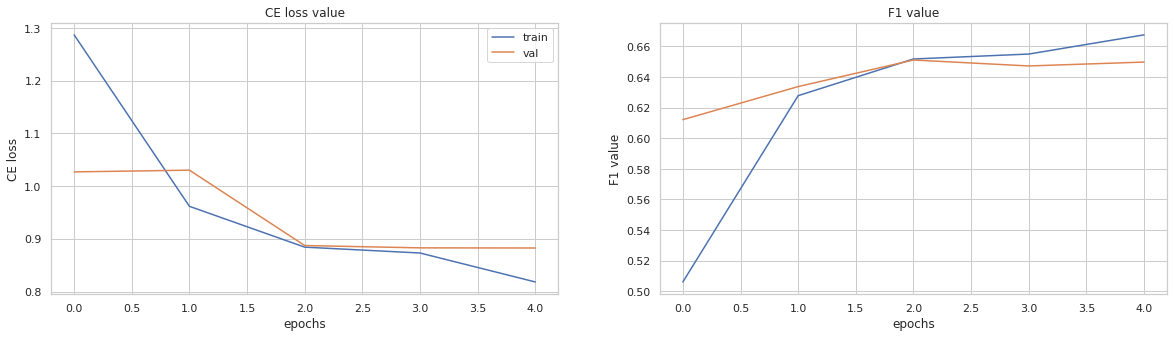

In [40]:
plot_losses(losses, val_losses, f1s, val_f1s)

Упс, не помогли. Попробуем с двумя фильтрами.

In [41]:
model = CNN_LSTM(len(train_dataset.word2id), embedding_dim=300, 
                 filter_number=150, filter_size=[2, 3], hidden_size=150, 
                 num_layers=1, weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.001)
losses, val_losses, f1s, val_f1s = model_perfomance(model, criterion, optimizer,
                                                   DEVICE, 5, train_iterator,
                                                   test_iterator)

  0%|          | 0/5 [00:00<?, ?it/s]


======== Epoch 1 / 5 ========
Evaluating on train...
F-score: 0.4563251733779907, loss: 1.380763315830101
Evaluating on test...
F-score: 0.6198149919509888, loss: 1.1017863025536407

======== Epoch 2 / 5 ========
Evaluating on train...
F-score: 0.6205573081970215, loss: 1.009255119732448
Evaluating on test...
F-score: 0.6312924027442932, loss: 0.9455093693088841

======== Epoch 3 / 5 ========
Evaluating on train...
F-score: 0.6583895683288574, loss: 0.8588872783038081
Evaluating on test...
F-score: 0.6536006927490234, loss: 0.8728514297588451

======== Epoch 4 / 5 ========
Evaluating on train...
F-score: 0.6790995001792908, loss: 0.7852467099825541
Evaluating on test...
F-score: 0.6690872311592102, loss: 0.8128563278430218

======== Epoch 5 / 5 ========
Evaluating on train...
F-score: 0.6923869252204895, loss: 0.7362977696113846
Evaluating on test...
F-score: 0.6739945411682129, loss: 0.8030987865216023


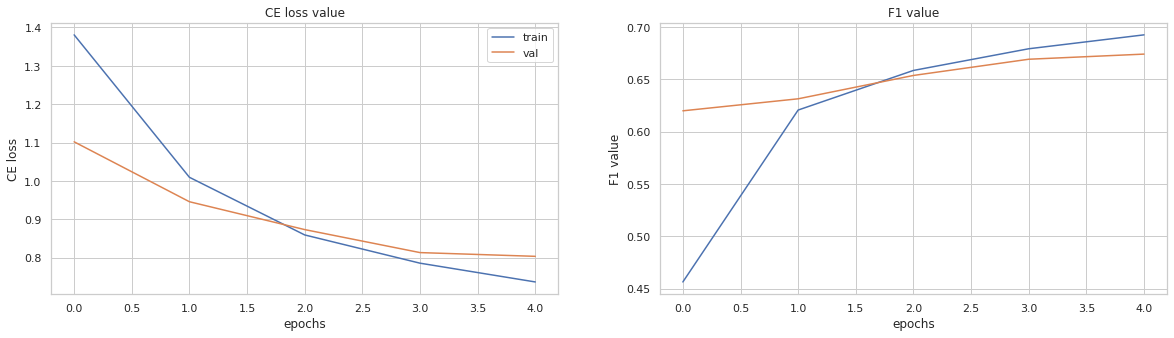

In [42]:
plot_losses(losses, val_losses, f1s, val_f1s)

Особо ничего не изменилось, попробуем с двумя LSTM слоями.

In [43]:
model = CNN_LSTM(len(train_dataset.word2id), embedding_dim=300, 
                 filter_number=150, filter_size=[2, 3], hidden_size=150, 
                 num_layers=2, weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.001)
losses, val_losses, f1s, val_f1s = model_perfomance(model, criterion, optimizer,
                                                   DEVICE, 5, train_iterator,
                                                   test_iterator)

  0%|          | 0/5 [00:00<?, ?it/s]


======== Epoch 1 / 5 ========
Evaluating on train...
F-score: 0.5117222666740417, loss: 1.276359541886518
Evaluating on test...
F-score: 0.614641010761261, loss: 1.007586060343562

======== Epoch 2 / 5 ========
Evaluating on train...
F-score: 0.6318597197532654, loss: 0.9581816042361616
Evaluating on test...
F-score: 0.6407840251922607, loss: 0.9180627851872831

======== Epoch 3 / 5 ========
Evaluating on train...
F-score: 0.6493926048278809, loss: 0.8822304322606042
Evaluating on test...
F-score: 0.6526702642440796, loss: 0.8693372091731509

======== Epoch 4 / 5 ========
Evaluating on train...
F-score: 0.6551944017410278, loss: 0.8768812312560827
Evaluating on test...
F-score: 0.6523103713989258, loss: 0.8537868744618183

======== Epoch 5 / 5 ========
Evaluating on train...
F-score: 0.668889045715332, loss: 0.8249304018864015
Evaluating on test...
F-score: 0.6564968228340149, loss: 0.8477132223747872


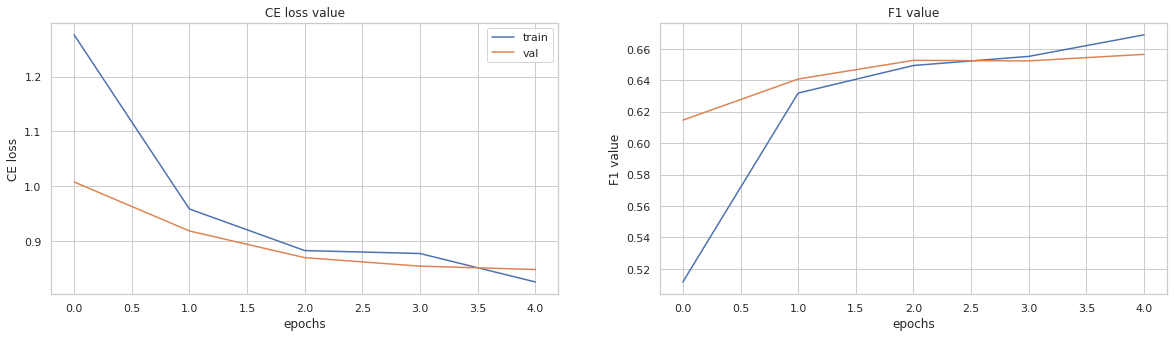

In [44]:
plot_losses(losses, val_losses, f1s, val_f1s)

Добавим фильтров. 

In [45]:
model = CNN_LSTM(len(train_dataset.word2id), embedding_dim=300, 
                 filter_number=150, filter_size=[2, 3, 4], hidden_size=150, 
                 num_layers=1, weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.001)
losses, val_losses, f1s, val_f1s = model_perfomance(model, criterion, optimizer,
                                                   DEVICE, 5, train_iterator,
                                                   test_iterator)

  0%|          | 0/5 [00:00<?, ?it/s]


======== Epoch 1 / 5 ========
Evaluating on train...
F-score: 0.5054563283920288, loss: 1.313142548207523
Evaluating on test...
F-score: 0.6069343686103821, loss: 1.0616336513209987

======== Epoch 2 / 5 ========
Evaluating on train...
F-score: 0.6238175630569458, loss: 0.9761900695002809
Evaluating on test...
F-score: 0.6147062182426453, loss: 1.0452333511532963

======== Epoch 3 / 5 ========
Evaluating on train...
F-score: 0.66367107629776, loss: 0.8493342894275172
Evaluating on test...
F-score: 0.6537981629371643, loss: 0.8394862059000376

======== Epoch 4 / 5 ========
Evaluating on train...
F-score: 0.6783707141876221, loss: 0.7894549657698391
Evaluating on test...
F-score: 0.5855494737625122, loss: 1.1022193286869977

======== Epoch 5 / 5 ========
Evaluating on train...
F-score: 0.6959050297737122, loss: 0.7349816682387371
Evaluating on test...
F-score: 0.6714484691619873, loss: 0.7852398737056835


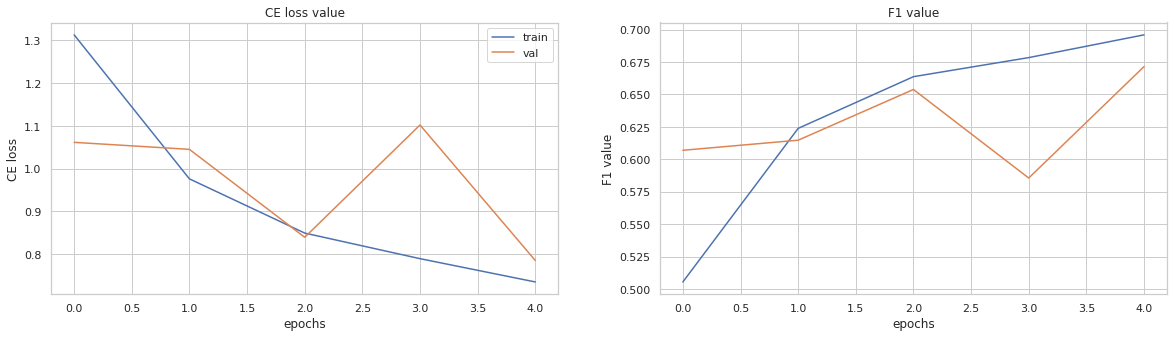

In [46]:
plot_losses(losses, val_losses, f1s, val_f1s)

Попробуем увеличить размерности выходов свёрток.

In [47]:
model = CNN_LSTM(len(train_dataset.word2id), embedding_dim=300, 
                 filter_number=300, filter_size=[2, 3, 4], hidden_size=150, 
                 num_layers=1, weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.001)
losses, val_losses, f1s, val_f1s = model_perfomance(model, criterion, optimizer,
                                                   DEVICE, 5, train_iterator,
                                                   test_iterator)

  0%|          | 0/5 [00:00<?, ?it/s]


======== Epoch 1 / 5 ========
Evaluating on train...
F-score: 0.5312398076057434, loss: 1.2978318402556335
Evaluating on test...
F-score: 0.593296229839325, loss: 1.0873100741489514

======== Epoch 2 / 5 ========
Evaluating on train...
F-score: 0.6117541193962097, loss: 0.9997445969354539
Evaluating on test...
F-score: 0.615890622138977, loss: 0.9626075786513251

======== Epoch 3 / 5 ========
Evaluating on train...
F-score: 0.6528855562210083, loss: 0.8737967663070783
Evaluating on test...
F-score: 0.6180605292320251, loss: 0.9468086490759978

======== Epoch 4 / 5 ========
Evaluating on train...
F-score: 0.6794242858886719, loss: 0.7771623803644764
Evaluating on test...
F-score: 0.6619322299957275, loss: 0.8408762313224174

======== Epoch 5 / 5 ========
Evaluating on train...
F-score: 0.6954629421234131, loss: 0.725027469956145
Evaluating on test...
F-score: 0.6769790053367615, loss: 0.7757801912926339


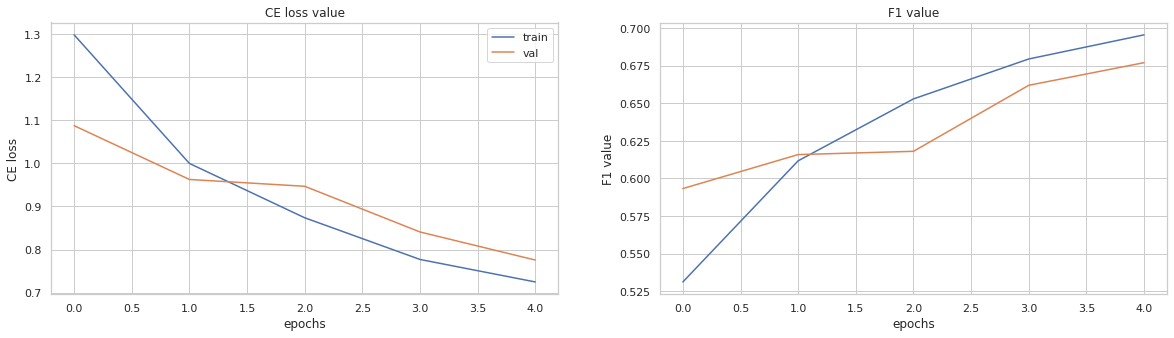

In [48]:
plot_losses(losses, val_losses, f1s, val_f1s)

Теперь добавим эпох.

In [49]:
model = CNN_LSTM(len(train_dataset.word2id), embedding_dim=300, 
                 filter_number=300, filter_size=[2, 3, 4], hidden_size=150, 
                 num_layers=1, weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.001)
losses, val_losses, f1s, val_f1s = model_perfomance(model, criterion, optimizer,
                                                   DEVICE, 10, train_iterator,
                                                   test_iterator)

  0%|          | 0/10 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Evaluating on train...
F-score: 0.550204336643219, loss: 1.183578335914482
Evaluating on test...
F-score: 0.6020760536193848, loss: 0.9947751631607881

======== Epoch 2 / 10 ========
Evaluating on train...
F-score: 0.6316091418266296, loss: 0.9276738620939708
Evaluating on test...
F-score: 0.6418267488479614, loss: 0.9054288300308021

======== Epoch 3 / 10 ========
Evaluating on train...
F-score: 0.6671923398971558, loss: 0.8231295047163152
Evaluating on test...
F-score: 0.5887573957443237, loss: 0.8804256658296328

======== Epoch 4 / 10 ========
Evaluating on train...
F-score: 0.6822077035903931, loss: 0.7481734359345469
Evaluating on test...
F-score: 0.6727668046951294, loss: 0.7930433879027495

======== Epoch 5 / 10 ========
Evaluating on train...
F-score: 0.69842529296875, loss: 0.6907120716004145
Evaluating on test...
F-score: 0.673210859298706, loss: 0.7673801070935017

======== Epoch 6 / 10 ========
Evaluating on train...
F-score: 0.70772767066955

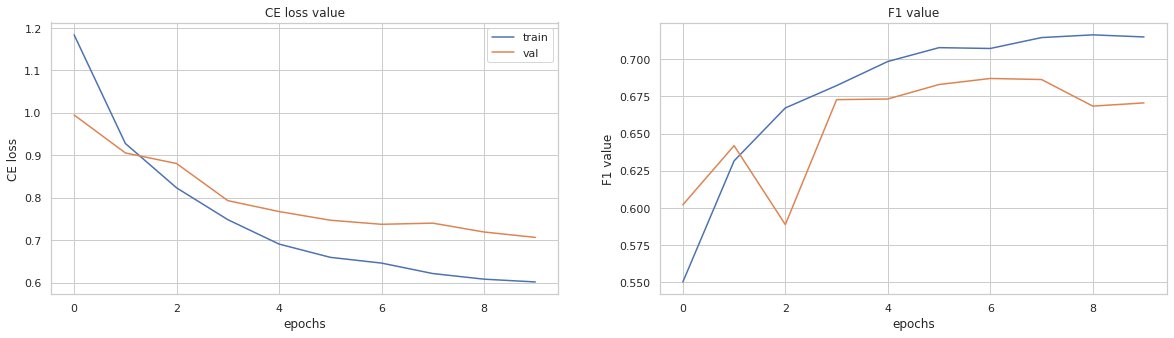

In [50]:
plot_losses(losses, val_losses, f1s, val_f1s)

Что-то как-то не очень помогли эпохи, но на всякий случай попробуем то же количество эпох на первоначальной размерности выходов свёрток. 

In [51]:
model = CNN_LSTM(len(train_dataset.word2id), embedding_dim=300, 
                 filter_number=150, filter_size=[2, 3, 4], hidden_size=150, 
                 num_layers=1, weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.001)
losses, val_losses, f1s, val_f1s = model_perfomance(model, criterion, optimizer,
                                                   DEVICE, 10, train_iterator,
                                                   test_iterator)

  0%|          | 0/10 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Evaluating on train...
F-score: 0.5564852356910706, loss: 1.2898322810121134
Evaluating on test...
F-score: 0.6143814921379089, loss: 1.0557143784858085

======== Epoch 2 / 10 ========
Evaluating on train...
F-score: 0.6133955717086792, loss: 1.0341198440311716
Evaluating on test...
F-score: 0.5938712358474731, loss: 1.03139489405864

======== Epoch 3 / 10 ========
Evaluating on train...
F-score: 0.638859212398529, loss: 0.9529742541767302
Evaluating on test...
F-score: 0.6293073892593384, loss: 0.9466143057153031

======== Epoch 4 / 10 ========
Evaluating on train...
F-score: 0.6586885452270508, loss: 0.8740624213705257
Evaluating on test...
F-score: 0.6622573733329773, loss: 0.8717595338821411

======== Epoch 5 / 10 ========
Evaluating on train...
F-score: 0.679766058921814, loss: 0.801422808040567
Evaluating on test...
F-score: 0.6604125499725342, loss: 0.88620988420538

======== Epoch 6 / 10 ========
Evaluating on train...
F-score: 0.6935400366783142

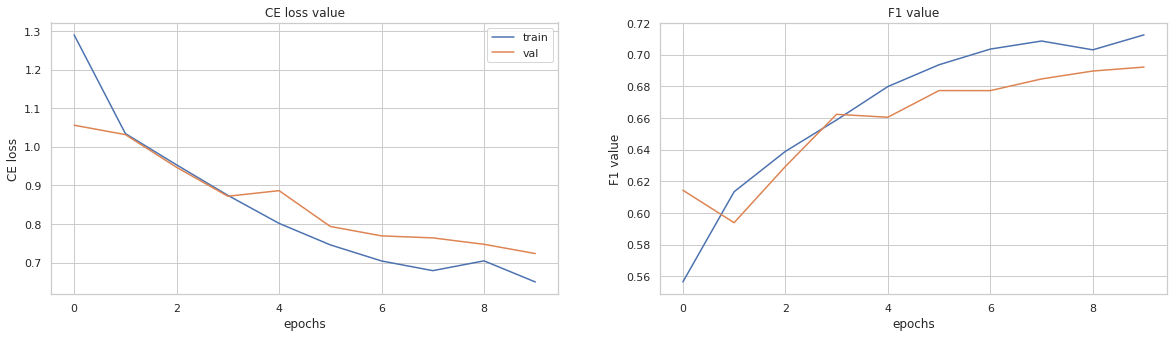

In [52]:
plot_losses(losses, val_losses, f1s, val_f1s)

Увы, эпохи не помогли.

### Выводы

* Лучшие результаты давала архитектура с 150 выходами у свёрток и LSTM на 5 эпох. Возможно, в данном случае можно ещё добавить эпох, и результаты улучшаться.
* Один LSTM слой оказался оптимальный для модели. 
* Как и в статье, один фильтр оказался лучше, чем несколько. 
* В целом результаты не очень, но это частично объясняется данными: они очень несбалансированы и, кажется, само распределение на классы довольно странное.

### RNN Cell

In [57]:
class RNNCell(nn.Module):

    def __init__(self, input_dimensions, hidden_size, bias=True):
        super().__init__()
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size
        self.bias = bias

        self.x2h = nn.Linear(input_dimensions, hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))

        hy = (self.x2h(input) + self.h2h(hx))
        
        return hy

### LSTM Cell

In [58]:
class LSTMCell(nn.Module):
    def __init__(self, input_dimensions, hidden_size, bias=True):
        super().__init__()
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size
        self.bias = bias

        self.xh = nn.Linear(input_dimensions, hidden_size * 4, bias=bias)
        self.hh = nn.Linear(hidden_size, hidden_size * 4, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))
            hx = (hx, hx)

        hx, cx = hx

        gates = self.xh(input) + self.hh(hx)

        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, 1)

        i_t = torch.sigmoid(input_gate)
        f_t = torch.sigmoid(forget_gate)
        g_t = torch.tanh(cell_gate)
        o_t = torch.sigmoid(output_gate)

        cy = cx * f_t + i_t * g_t
        hy = o_t * torch.tanh(cy)

        return (hy, cy)

### GRU Cell

In [55]:
class GRUCell(nn.Module):

    def __init__(self, input_dimensions, hidden_size, bias=True):
        super().__init__()
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size
        self.bias = bias

        self.x2h = nn.Linear(input_dimensions, 3 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))

        x_t = self.x2h(input)
        h_t = self.h2h(hx)

        x_reset, x_upd, x_new = x_t.chunk(3, 1)
        h_reset, h_upd, h_new = h_t.chunk(3, 1)

        reset_gate = torch.sigmoid(x_reset + h_reset)
        update_gate = torch.sigmoid(x_upd + h_upd)
        new_gate = torch.tanh(x_new + (reset_gate * h_new))

        hy = update_gate * hx + (1 - update_gate) * new_gate

        return hy

### RNN Layer

In [61]:
class RNNLayer(nn.Module):

    def __init__(self, input_dimensions, hidden_size, batch_size, layer):
        super().__init__()
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.layer = layer

        self.rnncell = RNNCell(self.input_dimensions, self.hidden_size)
        self.lstmcell = LSTMCell(self.input_dimensions, self.hidden_size)
        self.grucell = GRUCell(self.input_dimensions, self.hidden_size)
        
        self.h = torch.randn(self.batch_size, self.hidden_size)
        self.c = torch.randn(self.batch_size, self.hidden_size)

    def forward(self, X):
        out = []

        for i in range(len(X)):
          if self.layer == 'RNN':
              self.h = self.rnncell(X[i], self.h)
              h = self.h
          elif self.layer == 'LSTM':
              self.h, self.c = self.lstmcell(X[i], self.h, self.c)
              h = (self.h, self.c)
          elif self.layer == 'GRU':
              self.h = self.grucell(X[i], self.h)
              h = self.h
          out.append(self.h)  
        
        return out, h